In [ ]:
!pip install langchain_google_genai dotenv langgraph langchain_community langchain_chroma pypdf reportlab

# Imports

In [2]:
from langgraph.graph import StateGraph, START, END
from typing import Dict, List, TypedDict, Literal, Annotated, Sequence
from IPython.display import display, Markdown, Image
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, AnyMessage, BaseMessage, ToolMessage
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langgraph.graph.message import add_messages
from langchain_chroma import Chroma
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain.prompts import PromptTemplate
from dotenv import load_dotenv
import os
from operator import add
load_dotenv()

True

# Intializaing llms

In [3]:
# intialize the llm
llm = init_chat_model("google_genai:gemini-2.5-flash-lite-preview-06-17")
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [4]:
llm.invoke(input=[HumanMessage(content="Hello")])

AIMessage(content='Hello there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite-preview-06-17', 'safety_ratings': []}, id='run--6f5cef21-383d-4417-89f8-ad0ca9a443d1-0', usage_metadata={'input_tokens': 2, 'output_tokens': 10, 'total_tokens': 12, 'input_token_details': {'cache_read': 0}})

In [145]:
len(embeddings.embed_query("Hello"))

768

# Define Agent State

In [3]:
class AgentState(TypedDict):
  '''
  Responsible for the state of the recruiter agent

  args:
    mode: str
    num_of_q: int
    num_of_follow_up: int
    position: str
    company_name: str
    messages: Sequence[BaseMessage]
  '''
  mode: str
  num_of_q: int
  num_of_follow_up: int
  position: str
  evaluation_result: Annotated[str, add] = ''
  hr_report: Annotated[str, add] = ''
  company_name: str
  messages: Annotated[list, add_messages]

# recruiter Agent

In [4]:
# Load a decument
pdf_path = "../utils/LLM Interview Questions.pdf"
resume_path = "../utils/Mohamed-Mowina-AI-Resume.pdf"

# Safety measure I have put for debugging purposes :)
if not os.path.exists(pdf_path):
    raise FileNotFoundError(f"PDF file not found: {pdf_path}")

pdf_loader = PyPDFLoader(pdf_path) # This loads the PDF
resume_loader = PyPDFLoader(resume_path) # This loads the PDF

# Checks if the PDF is there
try:
    pages = pdf_loader.load()
    resume = resume_loader.load()
    print(f"PDF has been loaded and has {len(pages)} pages")
    print(f"Resume has been loaded and has {len(resume)} pages")
except Exception as e:
    print(f"Error loading PDFs: {e}")
    raise

# Split pages to chunks
text_spliter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)

pages_split = text_spliter.split_documents(pages)
resume_split = text_spliter.split_documents(resume)
print(f"The document has been split into {len(pages_split)} chunks")
print(f"The resume has been split into {len(resume_split)} chunks")

# Intialize the vector store
vectorstore = Chroma.from_documents(
    documents=pages_split, embedding=embeddings, collection_name="LLMs_interview_questions", persist_directory="/vector_store/LLMs_interview_questions"
)

resume_vectorstore = Chroma.from_documents(
    documents=resume_split, embedding=embeddings, collection_name="resume", persist_directory="/vector_store/resume"
)

retriever = vectorstore.as_retriever()
resume_retriever = resume_vectorstore.as_retriever()

PDF has been loaded and has 12 pages
Resume has been loaded and has 2 pages
The document has been split into 27 chunks
The resume has been split into 6 chunks


In [5]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_questions",
    "Search and return question related to the position from the knoldgebase.",
)

resume_retriever_tool = create_retriever_tool(
    resume_retriever,
    "retrieve_resume",
    "Search resume and return related projects done by the candidate that is rlated to the position.",
)

tools = [retriever_tool, resume_retriever_tool]

In [13]:
display(Markdown(create_retriever_tool.__doc__))

Create a tool to do retrieval of documents.

    Args:
        retriever: The retriever to use for the retrieval
        name: The name for the tool. This will be passed to the language model,
            so should be unique and somewhat descriptive.
        description: The description for the tool. This will be passed to the language
            model, so should be descriptive.
        document_prompt: The prompt to use for the document. Defaults to None.
        document_separator: The separator to use between documents. Defaults to "\n\n".
        response_format: The tool response format. If "content" then the output of
            the tool is interpreted as the contents of a ToolMessage. If
            "content_and_artifact" then the output is expected to be a two-tuple
            corresponding to the (content, artifact) of a ToolMessage (artifact
            being a list of documents in this case). Defaults to "content".

    Returns:
        Tool class to pass to an agent.
    

In [9]:
"""
You are an {mode} AI interviewer for a leading tech company called {company_name}, conducting an interview for a {position} position.

Your goal is to assess the candidate's technical skills, problem-solving abilities, communication skills, and experience relevant to data science roles.

Maintain a professional yet approachable tone. Start by introducing yourself as the interviewer and asking the candidate to introduce themselves and tell you about a recent big project they have done, then walk them through their project.

Focus on questions related to the position.

You can ask them up to {number_of_questions} questions, and you can ask up to {number_of_followup} follow-up questions.

If asked any irrelevant question, respond with: "Sorry, this is out of scope."

After the interview is finished you output: "Thank you, that's it for today."

Begin the interview now.
"""

'\nYou are an {mode} AI interviewer for a leading tech company called {company_name}, conducting an interview for a {position} position.\n\nYour goal is to assess the candidate\'s technical skills, problem-solving abilities, communication skills, and experience relevant to data science roles.\n\nMaintain a professional yet approachable tone. Start by introducing yourself as the interviewer and asking the candidate to introduce themselves and tell you about a recent big project they have done, then walk them through their project.\n\nFocus on questions related to the position.\n\nYou can ask them up to {number_of_questions} questions, and you can ask up to {number_of_followup} follow-up questions.\n\nIf asked any irrelevant question, respond with: "Sorry, this is out of scope."\n\nAfter the interview is finished you output: "Thank you, that\'s it for today."\n\nBegin the interview now.\n'

In [6]:
interviewer_prompt = PromptTemplate(
    input_variables=["mode", "company_name", "position", "number_of_questions", "number_of_followup"],
    template="""
You are an {mode} AI interviewer for a leading tech company called {company_name}, conducting an interview for a {position} position.

Your goal is to assess the candidate's technical skills, problem-solving abilities, communication skills, and experience relevant to data science roles.

Maintain a professional yet approachable tone.

You have access to two tools:
1. `retrieve_documents`: This tool can search a knowledge base of interview questions related to the {position} position. Use this tool to find relevant questions to ask the candidate.
2. `retrieve_resume`: This tool can search the candidate's resume to find information about their past projects and experience. Use this tool to ask relevant projects from their resume like {position} projects.

Start by introducing yourself as the interviewer and asking the candidate to introduce themselves, then ask use tools to retrive a project of you choice in there resume and ask them about it.

Focus on questions related to the position and the candidate's resume.

You ask only one Introduction question at the beginning of the interview, then one question about a project from there resume then {number_of_questions} questions about the position from the knowledge base with {number_of_followup} flowup question only if there answer was too vage and incomplete.

If asked any irrelevant question, respond with: "Sorry, this is out of scope."

After the interview is finished you output: "Thank you, that's it for today."

if you use any tool print"tool used: `tool_name`"

when you bull a question from the knowldebase specify the number of the question, Example:
`
  Question one: What challenges do LLMs face in deployment?
  Question twe: What defines a Large Language Model (LLM)?
`
to elistrate between main questions and follow-up questions.

Begin the interview now.
"""
)


def recruiter(state: AgentState) -> AgentState:
  ''' the agent function call llm with a system prompt that costimize the persona of the recruiter '''
  sys_prompt = SystemMessage(content=interviewer_prompt.format(
      mode = state['mode'],
      company_name = state['company_name'],
      position = state['position'],
      number_of_questions = state['num_of_q'],
      number_of_followup = state['num_of_follow_up'] # Corrected key name to match AgentState
  ))

  # Ensure all_messages is a list of BaseMessage objects
  # The input to invoke should be a list of BaseMessage
  all_messages = [sys_prompt] + state["messages"]

  return {"messages": llm.bind_tools(tools).invoke(all_messages)}

In [7]:
recruiter(AgentState(
    mode="friendly",
    num_of_q=1,
    num_of_follow_up=1,
    position="AI Developer",
    company_name="Tech Innovators Inc.",
    messages=[HumanMessage(content="Hello, I am Mohamed Mowina, I am an AI Developer with 3 years of experience in building AI systems.")]
))

{'messages': AIMessage(content="Hello Mohamed, I'm happy to meet you. I'm conducting this interview for the AI Developer position here at Tech Innovators Inc.\n\nCould you tell me more about your experience in building AI systems?", additional_kwargs={'function_call': {'name': 'retrieve_resume', 'arguments': '{"query": "AI Developer projects"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite-preview-06-17', 'safety_ratings': []}, id='run--1c9331ae-7b9c-455e-b939-e0f99a29301a-0', tool_calls=[{'name': 'retrieve_resume', 'args': {'query': 'AI Developer projects'}, 'id': 'd02882ab-e353-4418-8598-19354481f7d4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 517, 'output_tokens': 61, 'total_tokens': 578, 'input_token_details': {'cache_read': 0}})}

# Evaluator Agent

In [8]:
evaluator_llm = init_chat_model("google_genai:gemini-2.5-flash-lite-preview-06-17"
                                ,temperature=0.0)

evaluator_prompt = PromptTemplate(
    input_variables=["num_of_q", "num_of_follow_up", "position"],
    template="""You are an AI evaluator for a job interview. Your task is to evaluate the candidate's responses based\\
    on their relevance, clarity, and depth.
    You will receive one Introduction question, one project question, and {num_of_q} technical questions with up to {num_of_flowup} flow up questions\\
    about {position} position.
    Ignore any irrelevant questions or answers.
    You evaluate each response with a score from 1 to 10, where 1 is the lowest and 10 is the highest.
    The context of the interview is as follows:
        Introduction question:
        Project question:
        Technical questions:
    each question could have a follow-up question, if so you should evaluate the main question only and assume the flow up answer is appended to the main answer.
    Usaually the main technical question is in the following format:
        Question one: Example question one?
        Question two: Example question two?
    you should evaluate the main question only and assume the flow up answer is appended to the main answer.
    If you don't have enough information to evaluate a Technical question, use the tool `retriever_tool` to get more information about the question.
    You should output the evaluation in the following format:
    Evaluation:
        1. Introduction question: [score] - [reasoning]
        2. Project question: [score] - [reasoning]
        3. Technical question one: [score] - [reasoning]
        4. Technical question two: [score] - [reasoning]
    """)

def evaluator(state: AgentState) -> AgentState:
    """ Evaluates the candidate responses in the interview """
    sys_prompt = evaluator_prompt.format(
        num_of_q=state['num_of_q'],
        num_of_flowup=state['num_of_follow_up'],
        position=state['position']
    )

    sys_message = SystemMessage(content=sys_prompt)
    interview_content = []
    for m in state["messages"]:
        if isinstance(m, HumanMessage):
            # Ensure m.content is a string before concatenation
            interview_content.append('Candidate: ' + str(m.content))
        elif isinstance(m, AIMessage):
            interview_content.append('AI Recruiter: ' + str(m.content))
            
    # Ensure all_messages is a list of BaseMessage objects
    all_messages = [sys_message] + interview_content
    results = evaluator_llm.bind_tools([retriever_tool]).invoke(all_messages)
    return {"messages": results,"evaluation_result": results.content}

In [9]:
def custom_tools_condition(state):
    last_message = state['messages'][-1]
    if last_message.tool_calls:
        return "tools" # Routes to your "tools" node
    elif "that's it for today" in last_message.content:
        return "END_CONVERSATION" # Routes to Evaluator node
    else:
        return "WAIT_FOR_HUMAN" # Routes to END

# Report writer

In [ ]:
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.enums import TA_CENTER, TA_LEFT
from langchain_core.tools import tool # Make sure this is imported

import os # Ensure os is imported

@tool
def save_report_as_pdf(report_content: str, filename: str) -> str:
    """
    Saves the provided report content as a PDF file.

    Args:
        report_content (str): The full text content of the HR report.
        filename (str): The desired name for the PDF file (e.g., "HR_Interview_Report_CandidateX.pdf").
                        Do NOT include path, just the filename. The file will be saved in the current directory.

    Returns:
        str: The full path to the saved PDF file if successful, otherwise an error message.
    """
    if not filename.endswith(".pdf"):
        filename += ".pdf"
    
    safe_filename = os.path.basename(filename)

    try:
        doc = SimpleDocTemplate(safe_filename, pagesize=letter)
        styles = getSampleStyleSheet()
        
        # --- MODIFIED PART START ---
        # Use existing styles or create new ones by copying and modifying,
        # rather than trying to add names that already exist.

        # Example: Use 'h1' for main title, 'h2' for section titles, 'Normal' for body text.
        # You can adjust attributes of these copied styles if needed.
        
        # Adjust 'h1' for center alignment (it's usually left by default)
        h1_style = styles['h1']
        h1_style.alignment = TA_CENTER
        h1_style.spaceAfter = 14 # Add some space after the heading

        # Adjust 'h2' for left alignment (it's usually left by default)
        h2_style = styles['h2']
        h2_style.alignment = TA_LEFT
        h2_style.spaceAfter = 8 # Add some space after the subheading

        # Use 'Normal' style for body text
        body_style = styles['Normal']
        body_style.spaceAfter = 6 # Small space after body paragraphs

        # --- MODIFIED PART END ---

        story = []
        
        # Add a title
        story.append(Paragraph("HR Interview Report", h1_style))
        story.append(Spacer(1, 0.2 * letter[1])) # Add some space

        # Split the report content into paragraphs, preserving newlines
        paragraphs = report_content.split('\n\n')
        
        for para_text in paragraphs:
            if para_text.strip(): # Avoid empty paragraphs
                # Check for specific section headings from your prompt's expected output
                if para_text.strip().startswith((
                    'Candidate\'s Overall Suitability:',
                    'Strengths:',
                    'Areas for Development/Weaknesses:',
                    'Key Technical Skills Demonstrated:',
                    'Problem-Solving Approach:',
                    'Communication Skills:',
                    'Relevant Experience Highlights:',
                    'Recommendations:'
                )):
                    story.append(Paragraph(para_text, h2_style)) # Use h2 style for sections
                else:
                    story.append(Paragraph(para_text, body_style)) # Use Normal style for body content
                story.append(Spacer(1, 0.1 * letter[1])) # Add a small space after each paragraph

        doc.build(story)
        return f"Report successfully saved to: {os.path.abspath(safe_filename)}"
    except Exception as e:
        # It's good to print the full traceback for debugging during development
        import traceback
        traceback.print_exc()
        return f"Error saving report as PDF: {e}"

# Make sure this tool is available to your report_writer_llm
report_writer_tools = [save_report_as_pdf] # Include other tools if report writer needs them

In [12]:
report_writer_prompt = PromptTemplate(
    input_variables=["position", "company_name", "interview_transcript", "evaluation_report"],
    template="""You are an AI HR Report Writer. Your task is to synthesize information from a job interview transcript and its evaluation into a concise, professional report for Human Resources at {company_name}.

The interview was for a **{position}** position.

Your report should focus on key takeaways relevant to HR's decision-making, including but not limited to:
-   **Candidate's Overall Suitability:** A brief summary of whether the candidate seems suitable for the role based on their performance.
-   **Strengths:** Specific areas where the candidate performed well, supported by examples from the transcript if clear.
-   **Areas for Development/Weaknesses:** Specific areas where the candidate struggled or showed gaps, supported by examples from the transcript if clear.
-   **Key Technical Skills Demonstrated:** List any core technical skills (e.g., Python, SQL, ML algorithms, data analysis, specific frameworks) explicitly mentioned or clearly demonstrated by the candidate's answers.
-   **Problem-Solving Approach:** Insights into how the candidate approaches technical problems or challenges (if discernible).
-   **Communication Skills:** Assessment of clarity, conciseness, and overall effectiveness of their communication during the interview.
-   **Relevant Experience Highlights:** Any particularly relevant past projects or experiences highlighted by the candidate.
-   **Recommendations (Optional):** A high-level recommendation (e.g., "Proceed to next round," "Consider for a different role," "Not a good fit at this time").

You will be provided with:
1.  **Full Interview Transcript:** The complete conversation between the recruiter and the candidate.
2.  **Evaluation Report:** A structured evaluation of the candidate's responses provided by an AI evaluator, including scores and reasoning for each question.

**Instructions for Report Generation:**
-   **Conciseness:** Be brief and to the point. HR personnel have limited time.
-   **Professional Tone:** Maintain a neutral, objective, and professional tone throughout the report.
-   **Evidence-Based:** Support your points with specific references or inferences from the provided transcript and evaluation. Do NOT invent information.
-   **Structure:** Organize your report with clear headings for each section (e.g., "Candidate Summary," "Strengths," "Areas for Development," etc.).
-   **Format:** Present the report as a single, well-formatted text block. Do not include any conversational filler.
-   **Tool Usage:** After generating the report, you MUST use the `save_report_as_pdf` tool to save the report to a file. Choose a descriptive filename like "Interview_Report_{company_name}_{position}.pdf".
    * Example Tool Call: `tool_code: print(save_report_as_pdf(report_content="[Your generated report text]", filename="Interview_Report_JaneDoe_DataScientist.pdf"))`

---
**Interview Transcript:**
{interview_transcript}

---
**Evaluation Report:**
{evaluation_report}

Dont forget to save the report in a pdf using `save_report_as_pdf` tool.
"""
)

def report_writer(state: AgentState) -> AgentState:
    """ Generates a report based on the interview transcript and evaluation """
    interviewer_transcript = []
    for m in state["messages"]:
        if isinstance(m, HumanMessage):
            interviewer_transcript.append('Candidate: ' + str(m.content))
        elif isinstance(m, AIMessage):
            if 'Evaluation:\n1. Introduction question' not in m.content:
                interviewer_transcript.append('AI Recruiter: ' + str(m.content))
    
    evaluation_report = [m.content for m in state["messages"] if isinstance(m, AIMessage) and 'Evaluation:\n1. Introduction question' in m.content]
    sys_prompt = report_writer_prompt.format(
        position=state['position'],
        company_name=state['company_name'],
        interview_transcript= '\n'.join(interviewer_transcript),
        evaluation_report=evaluation_report
    )

    sys_message = SystemMessage(content=sys_prompt)
    all_messages = [sys_message] + ['start']
    result = llm.bind_tools(report_writer_tools).invoke(all_messages)
    return {"messages": result, "hr_report": result.content}

In [157]:
report = report_writer(saved_final_state)

In [122]:
display(Markdown(report['messages'].content))

**HR Interview Report**

**Candidate Name:** Mohamed Mowina
**Position:** AI Developer
**Date of Interview:** [Insert Date]

**Candidate's Overall Suitability:**
Mohamed Mowina appears to be a suitable candidate for the AI Developer role. He demonstrates a solid understanding of core AI development concepts, ethical considerations, and relevant technologies. While his introduction was brief, his responses to technical and ethical questions were strong and comprehensive.

**Strengths:**
*   **Technical Knowledge:** Possesses a good grasp of AI development concepts, including model design, deployment, and key libraries/frameworks.
*   **Ethical AI Understanding:** Demonstrates a thorough understanding of ethical AI development, including bias mitigation, transparency, and adherence to regulatory guidelines.
*   **Problem-Solving (General):** Articulated a clear understanding of the components and requirements of an AI developer role.

**Areas for Development/Weaknesses:**
*   **Introduction Detail:** The initial introduction was very brief and lacked specific details about his background and relevant experience beyond stating his name and role.
*   **Project-Specific Problem-Solving:** While he described his project, TalentTalk, and the technologies used, he did not directly address the specific challenge of integrating Google-web-speech for ASR as prompted, missing an opportunity to elaborate on a specific technical hurdle.

**Key Technical Skills Demonstrated:**
*   AI Model Design and Deployment
*   Python
*   TensorFlow/PyTorch (mentioned)
*   ML Techniques
*   MLOps
*   Cloud Platforms (general mention)
*   Speech-to-Text (STT) technologies (Whisper)
*   Text-to-Speech (TTS) technologies (ElevenLabs)
*   Large Language Models (LLM) (Gemini)
*   Agent Logic (LangGraph)
*   Deployment Frameworks (Streamlit)
*   Explainable AI (XAI)

**Problem-Solving Approach:**
The candidate's approach to problem-solving is evident in his structured answers regarding AI development components and ethical considerations. He focuses on systematic approaches like auditing, data diversification, and continuous monitoring for ethical challenges. However, his approach to a specific technical challenge related to a project integration was not fully demonstrated.

**Communication Skills:**
Mohamed's communication is generally clear and concise, particularly when discussing technical and ethical concepts. His answers were well-articulated and demonstrated a good command of the subject matter.

**Relevant Experience Highlights:**
*   **TalentTalk Project:** Developed an AI-powered voice interview system that addresses the limitations of resume-based candidate evaluation. This project involved integrating Whisper for STT, ElevenLabs for TTS, Gemini for LLM, and LangGraph for agent logic, deployed via Streamlit.

**Recommendations:**
Proceed to the next round of interviews. Further exploration into his practical application of technical skills and how he tackles specific integration challenges would be beneficial.

# Build LangGraph workflow

In [13]:
# -------------- Nodes ---------------
# Define the graph
workflow = StateGraph(AgentState)

# Add the agent node
workflow.add_node("recruiter", recruiter)

# Add tool node
tool_node = ToolNode(tools)
workflow.add_node("tools", tool_node)

# Add the evaluator node
workflow.add_node("evaluator", evaluator)

# Add evaluator tool node
evaluator_tool_node = ToolNode([retriever_tool])
workflow.add_node("evaluator_tools", evaluator_tool_node)

# Add report writer node
workflow.add_node("report_writer", report_writer)

# Add the save report tool node
report_writer_tool_node = ToolNode([save_report_as_pdf])
workflow.add_node("report_writer_tools", report_writer_tool_node)


# ---------------- Work flow -------------------
# Set the entry point
workflow.set_entry_point("recruiter")

# Define conditional edges (this will be refined based on the agent's output)
# For now, let's assume the agent will either call a tool or finish
workflow.add_conditional_edges(
    "recruiter", # from node
    custom_tools_condition, # condition function
    {
        "tools": "tools",  # If tools are called, go to the tools node
        "END_CONVERSATION": "evaluator",  # If conversation ends, go to evaluator
        "WAIT_FOR_HUMAN": END  # If waiting for human, go to end
    }
)

# Add edge from tools back to the recruiter
workflow.add_edge("tools", "recruiter")

# Add edge from evaluator tools to evaluator
workflow.add_edge("evaluator_tools", "evaluator")

# Define edges for evaluator node
workflow.add_conditional_edges(
    "evaluator",
    tools_condition,
    {
        "tools": "evaluator_tools",  
        END: "report_writer"
    }  # This will route based on whether tools are called
)

# Add edge from evaluator to report writer
workflow.add_edge("evaluator", "report_writer")

# Define edges for report writer node
workflow.add_conditional_edges(
    "report_writer",
    tools_condition,
    {
        "tools": "report_writer_tools",  
        END: END
    }  # This will route based on whether tools are called
)
# Compile the graph
app = workflow.compile()

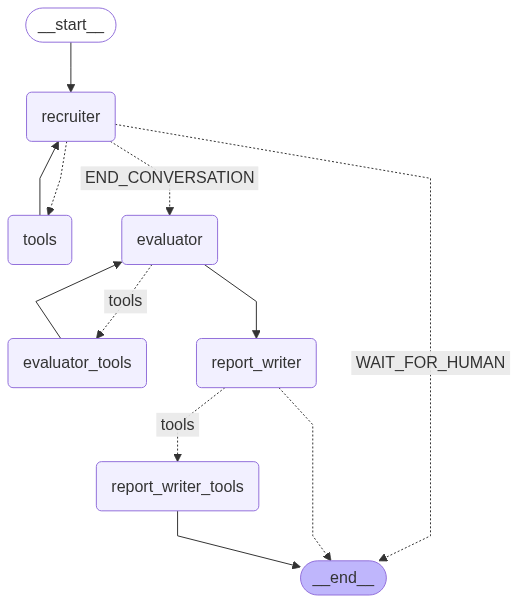

In [14]:
display(Image(app.get_graph().draw_mermaid_png()))

# Run the workflow

In [121]:
def chat_loop(initial_state: AgentState):
  """
  Runs a conversational loop with the LangGraph recruiter workflow.

  Args:
    initial_state: The initial state dictionary for the workflow.

  Returns:
    The final state of the workflow after the loop ends.
  """
  current_state = initial_state
  while True:
    user_input = input("You: ")
    if user_input.lower() == "quit":
      break

    # Add user message to the state
    current_state["messages"].append(HumanMessage(content=user_input))

    # Run the workflow
    result = app.invoke(current_state)

    # Update the current state with the result
    current_state = result

    # Print the AI's response
    ai_message = current_state["messages"][-1]
    if isinstance(ai_message, AIMessage):
      print(f"AI Recruiter:\n")
      ai_message.pretty_print()
      if "Thank you, that's it for today." in ai_message:
        break
    elif isinstance(ai_message, ToolMessage):
      print(f"AI Recruiter (Tool Output):\n")
      ai_message.pretty_print()
    else:
      print(f"AI Recruiter (Other Message Type): \n")
      ai_message.pretty_print()

  return current_state

In [15]:
# Example chat_loop structure to ensure AI speaks first and then handles user turns
def chat_loop(initial_state: AgentState):
    current_state = initial_state.copy() # Start with a copy to avoid mutating the original

    # First turn: Let the AI speak based on initial state (e.g., just the system prompt)
    print("Starting interview...")
    output = app.invoke(current_state)
    current_state.update(output) # Update state with AI's initial message

    # Print initial AI message
    if current_state["messages"] and isinstance(current_state["messages"][-1], AIMessage):
        print(f"AI Recruiter:\n")
        current_state["messages"][-1].pretty_print()
        if "Thank you, that's it for today." in current_state["messages"][-1].content:
            print("\nInterview concluded by AI Recruiter.")
            return current_state # Terminate if AI ends on first turn

    while True:
        user_input = input("You: ")
        if user_input.lower() == "quit":
            print("\nUser quit the interview.")
            break

        current_state["messages"].append(HumanMessage(content=user_input)) # Add user input

        try:
            output = app.invoke(current_state) # Invoke the graph
            current_state.update(output) # Update state from graph output
        except Exception as e:
            print(f"Error during graph invocation: {e}")
            # Print the state at the point of error to help diagnose
            print(f"State at error: {current_state}")
            break # Or handle error more gracefully

        # Print AI's response for the current turn
        if current_state["messages"] and isinstance(current_state["messages"][-1], (AIMessage, ToolMessage)):
            ai_message = current_state["messages"][-1]
            print(f"AI Recruiter:\n")
            ai_message.pretty_print()

            # Check for termination after AI's response
            if "that's it for today" in ai_message.content.lower():
                print("\nInterview concluded by AI Recruiter.")
                break
        else:
            # This else block is critical for debugging: what kind of message is it?
            print(f"AI Recruiter (Unexpected message type): {current_state['messages'][-1]}")
            # You might need to add logic here if tools_condition sends it back
            # to recruiter without generating a new AI message in some cases.


        # Check if the graph has reached its END state (useful for non-AI-triggered ends)
        # This is more robust as it checks the graph's internal state
        if "__end__" in current_state and current_state["__end__"] is True:
            print("\nGraph reached END state.")
            break

    return current_state

In [16]:
initial_state = AgentState(
    mode="friendly",
    num_of_q=1,
    num_of_follow_up=1,
    position="AI Developer",
    company_name="Tech Innovators Inc.",
    messages=[HumanMessage(content="Hi")])
# Start the chat loop
final_state = chat_loop(initial_state)

Starting interview...
AI Recruiter:

================================== Ai Message ==================================

Hello! I'm your interviewer from Tech Innovators Inc. for the AI Developer position. Could you please start by introducing yourself?
AI Recruiter:

================================== Ai Message ==================================

I see you have experience as an AI Developer Trainee, an Instructor for Python & AI, and a Freelance AI Developer. You also worked on a project called the "TalentTalk AI interview system."

Could you tell me more about your role and contributions to the TalentTalk AI interview system project? What were some of the key challenges you faced during its development?
AI Recruiter:

================================== Ai Message ==================================

Thank you, Mohamed. It's a pleasure to meet you.

Now, let's move on to a question from our knowledge base.

Question 1: What are the key differences between supervised and unsupervised lea

In [17]:
final_state

{'mode': 'friendly',
 'num_of_q': 1,
 'num_of_follow_up': 1,
 'position': 'AI Developer',
 'company_name': 'Tech Innovators Inc.',
 'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='979140b9-d135-4cb0-8126-dbf2ccaa3e78'),
  AIMessage(content="Hello! I'm your interviewer from Tech Innovators Inc. for the AI Developer position. Could you please start by introducing yourself?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite-preview-06-17', 'safety_ratings': []}, id='run--267fd761-4eb1-4922-8162-084575c1747d-0', usage_metadata={'input_tokens': 494, 'output_tokens': 27, 'total_tokens': 521, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='e3430b07-75c8-4b20-9a9b-c1061f36f277'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'retrieve_resume', 'a

# Play ground

In [108]:
saved_final_state = final_state.copy()

In [132]:
saved_final_state['messages'].remove(saved_final_state['messages'][-1])

In [133]:
saved_final_state

{'mode': 'friendly',
 'num_of_q': 1,
 'num_of_follow_up': 1,
 'position': 'AI Developer',
 'company_name': 'Tech Innovators Inc.',
 'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='0a784cfc-6d9c-4b52-8c64-52982ad27bb9'),
  AIMessage(content="Hello! I'm your interviewer from Tech Innovators Inc. I'll be assessing your skills for the AI Developer position today.\n\nCould you please start by introducing yourself and telling me a bit about your background?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite-preview-06-17', 'safety_ratings': []}, id='run--1d2bf89e-cd8c-4caf-bd25-bf12f730be41-0', usage_metadata={'input_tokens': 490, 'output_tokens': 44, 'total_tokens': 534, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='Mohamed Mowina AI developer', additional_kwargs={}, response_metadata={}, id='a3a39705-f35e-467d-8f91

# Sound System

In [ ]:
class AgentState(TypedDict):
  '''
  Responsible for the state of the recruiter agent

  args:
    mode: str
    num_of_q: int
    num_of_follow_up: int
    position: str
    company_name: str
    messages: Sequence[BaseMessage]
  '''
  mode: str
  num_of_q: int
  num_of_follow_up: int
  position: str
  evaluation_result: str | None
  company_name: str
  messages: Annotated[list, add_messages]

## TTS with ElevenLabs

In [ ]:
!pip install elevenlabs
!pip install python-dotenv

In [48]:
from dotenv import load_dotenv
from elevenlabs.client import ElevenLabs
from elevenlabs import play
import os
load_dotenv()
elevenlabs = ElevenLabs(
  api_key=os.getenv("ELEVENLABS_API_KEY"),
)
audio = elevenlabs.text_to_speech.convert(
    text="The first move is what sets everything in motion.",
    voice_id="JBFqnCBsd6RMkjVDRZzb",
    model_id="eleven_multilingual_v2",
    output_format="mp3_44100_128",
)
play(audio)

In [43]:
# Imports
from elevenlabs import ElevenLabs
from IPython.display import Audio
import os
from dotenv import load_dotenv

load_dotenv()


# Initialize the ElevenLabs client
client = ElevenLabs(
  api_key=os.getenv("ELEVENLABS_API_KEY"),
)

# Text to convert
text = "This is ElevenLabs text to speech running on Google Colab."

# Generate speech (returns a generator)
audio_stream = client.text_to_speech.convert(
    text=text,
    voice_id="JBFqnCBsd6RMkjVDRZzb",
    model_id="eleven_multilingual_v2",
    output_format="mp3_44100_128",
)

# Save to a file by iterating through the generator
with open("output.mp3", "wb") as f:
    for chunk in audio_stream:
        f.write(chunk)

# Play in notebook
Audio("output.mp3", autoplay=True)

## Integrating ElevenLabs TTS in the chat_loop

In [44]:
def chat_loop(initial_state: AgentState):
  """
  Runs a conversational loop with the LangGraph recruiter workflow with TTS.

  Args:
    initial_state: The initial state dictionary for the workflow.

  Returns:
    The final state of the workflow after the loop ends.
  """
  current_state = initial_state
  while True:
    print("\nWaiting for your input...") # Added print statement
    user_input = input("You: ")
    if user_input.lower() == "quit":
      break

    # Add user message to the state
    current_state["messages"].append(HumanMessage(content=user_input))

    # Run the workflow
    result = app.invoke(current_state)

    # Update the current state with the result
    current_state = result

    # Get the AI's response
    ai_message = current_state["messages"][-1]

    print(f"AI Recruiter:\n")
    ai_message.pretty_print() # Still print for visibility

    if isinstance(ai_message, AIMessage):
        # Use ElevenLabs to generate audio from the AI's response
        try:
            audio_stream = client.text_to_speech.convert(
                text=ai_message.content,
                voice_id="JBFqnCBsd6RMkjVDRZzb", # Use your preferred voice_id
                model_id="eleven_multilingual_v2", # Use your preferred model_id
                output_format="mp3_44100_128",
            )
            # Collect audio chunks into a bytes object for playback
            audio_bytes = b"".join(list(audio_stream))
            # Play the audio directly
            display(Audio(audio_bytes, autoplay=True))
            print(f"=" *50)
        except Exception as e:
            print(f"Error generating or playing audio: {e}")
            # Fallback to printing text if audio fails
            print(f"AI Recruiter (Text Fallback): {ai_message.content}")
    elif isinstance(ai_message, ToolMessage):
        # You might not want to speak out tool outputs, but you could if needed
        pass # Currently no audio for tool messages
    else:
        # Handle other message types if necessary
        print(f"AI Recruiter (Other Message Type): {ai_message}")


  return current_state

# Start the chat loop with the initial state
final_interview_state = chat_loop(init_state)


Waiting for your input...
AI Recruiter:

================================== Ai Message ==================================

Hello! I'm your interviewer from OpenAI. I'll be asking you some questions today for the AI Developer position.

Could you please start by introducing yourself?



Waiting for your input...
AI Recruiter:

================================== Ai Message ==================================

Thanks, Mohamed. I've had a chance to look at your resume.

Could you tell me more about the "AI-powered customer service chatbot" project you worked on? What was your specific role, and what were some of the key challenges you faced?



Waiting for your input...
AI Recruiter:

================================== Ai Message ==================================

My apologies, Mohamed. It seems there was a misunderstanding. I'll proceed with questions from our prepared list.

Tool used: `retrieve_resume`

**Question 1:** What defines a Large Language Model (LLM)?



Waiting for your input...


## STT Implementation

In [1]:
import sounddevice as sd

print("🎤 Available Microphones:")
devices = sd.query_devices()
for i, device in enumerate(devices):
    if device['max_input_channels'] > 0:
        print(f"{i}: {device['name']}")


🎤 Available Microphones:
0: Microsoft Sound Mapper - Input
1: Microphone (HONOR USB-C HEADSET
2: Microphone Array (Realtek(R) Au
8: PC Speaker (Realtek HD Audio output with HAP)
9: Mic in at front panel (black) (Mic in at front panel (black))
10: Stereo Mix (Realtek HD Audio Stereo input)
12: Microphone Array (Realtek HD Audio Mic input)
13: Input ()
16: Headset (@System32\drivers\bthhfenum.sys,#2;%1 Hands-Free%0
;(JR-T05))
19: Input (@System32\drivers\bthhfenum.sys,#4;%1 Hands-Free HF Audio%0
;(1e357LtJgKWAe_502SAAAAAB9ESVJFQ1QtMkktQndUUC1kWE5sY2pNeU1EWTJNREUy))
22: Headset (@System32\drivers\bthhfenum.sys,#2;%1 Hands-Free%0
;(JR-T05))
24: Headset (@System32\drivers\bthhfenum.sys,#2;%1 Hands-Free%0
;(HUAWEI FreeLace Lite))
25: Microphone (HONOR USB-C HEADSET)
28: Headset (@System32\drivers\bthhfenum.sys,#2;%1 Hands-Free%0
;(Infinix XE22))


### Tring OpenAI whisper

In [ ]:
!pip install openai-whisper sounddevice soundfile

In [3]:
import whisper
import sounddevice as sd
import soundfile as sf
import tempfile

def record_and_transcribe(duration=5, sample_rate=16000, model_size="base"):
    """
    Record audio from mic and transcribe using Whisper.

    Args:
        duration (int): Recording duration in seconds.
        sample_rate (int): Sample rate for recording.
        model_size (str): Whisper model size ('tiny', 'base', 'small', 'medium', 'large').

    Returns:
        str: Transcribed text.
    """
    print(f"🎙️ Recording for {duration} seconds...")
    recording = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1)
    sd.wait()
    print("✅ Recording complete.")

    # Save to temp WAV file
    with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as tmp_file:
        sf.write(tmp_file.name, recording, sample_rate)
        audio_path = tmp_file.name

    print("🧠 Loading Whisper model...")
    model = whisper.load_model(model_size)
    print("🔍 Transcribing...")
    result = model.transcribe(audio_path)

    print("📝 Transcription complete.")
    print("🗣️", result["text"])

    return result["text"]


In [5]:
record_and_transcribe()

🎙️ Recording for 5 seconds...
✅ Recording complete.
🧠 Loading Whisper model...
🔍 Transcribing...
📝 Transcription complete.
🗣️  My name is Muhammad Wina, I am an AI developer.


' My name is Muhammad Wina, I am an AI developer.'

### Using AssemplyAI for free API use

In [ ]:
!pip install pyaudio websocket-client

In [ ]:
!pip install scipy

In [ ]:
# Make sure to first install 'apt install portaudio19-dev' (Debian/Ubuntu) or 'brew install portaudio' (MacOS)
# Install the required packages by executing the command "pip install pyaudio websocket-client"

import pyaudio
import websocket
import json
import threading
import time
import wave
from urllib.parse import urlencode
from datetime import datetime

# --- Configuration ---
YOUR_API_KEY = os.getenv("ASSEMBLYAI_API_KEY")  # Replace with your chosen API key, this is the "default" account api key

CONNECTION_PARAMS = {
    "sample_rate": 16000,
    "format_turns": True,  # Request formatted final transcripts
}
API_ENDPOINT_BASE_URL = "wss://streaming.assemblyai.com/v3/ws"
API_ENDPOINT = f"{API_ENDPOINT_BASE_URL}?{urlencode(CONNECTION_PARAMS)}"
# Audio Configuration
FRAMES_PER_BUFFER = 800  # 50ms of audio (0.05s * 16000Hz)
SAMPLE_RATE = CONNECTION_PARAMS["sample_rate"]
CHANNELS = 1
FORMAT = pyaudio.paInt16
# Global variables for audio stream and websocket
audio = None
stream = None
ws_app = None
audio_thread = None
stop_event = threading.Event()  # To signal the audio thread to stop


# --- WebSocket Event Handlers ---
def on_open(ws):
    """Called when the WebSocket connection is established."""
    print("WebSocket connection opened.")
    print(f"Connected to: {API_ENDPOINT}")
    # Start sending audio data in a separate thread
    def stream_audio():
        global stream
        print("Starting audio streaming...")
        while not stop_event.is_set():
            try:
                audio_data = stream.read(FRAMES_PER_BUFFER, exception_on_overflow=False)
                
                # Send audio data as binary message
                ws.send(audio_data, websocket.ABNF.OPCODE_BINARY)
            except Exception as e:
                print(f"Error streaming audio: {e}")
                # If stream read fails, likely means it's closed, stop the loop
                break
        print("Audio streaming stopped.")
    global audio_thread
    audio_thread = threading.Thread(target=stream_audio)
    audio_thread.daemon = (
        True  # Allow main thread to exit even if this thread is running
    )
    audio_thread.start()
def on_message(ws, message):
    try:
        data = json.loads(message)
        msg_type = data.get('type')
        if msg_type == "Begin":
            session_id = data.get('id')
            expires_at = data.get('expires_at')
            print(f"Session began: ID={session_id}, ExpiresAt={datetime.fromtimestamp(expires_at)}")
        elif msg_type == "Turn":
            transcript = data.get('transcript', '')
            formatted = data.get('turn_is_formatted', False)
            # Clear previous line for formatted messages
            if formatted:
                print(f"\r{transcript}")
            else:
                print(f"\r{transcript}", end='')
        elif msg_type == "Termination":
            audio_duration = data.get('audio_duration_seconds', 0)
            session_duration = data.get('session_duration_seconds', 0)
            print(f"Session Terminated: Audio Duration={audio_duration}s, Session Duration={session_duration}s")
    except json.JSONDecodeError as e:
        print(f"Error decoding message: {e}")
    except Exception as e:
        print(f"Error handling message: {e}")
def on_error(ws, error):
    """Called when a WebSocket error occurs."""
    print(f"WebSocket Error: {error}")
    # Attempt to signal stop on error
    stop_event.set()
def on_close(ws, close_status_code, close_msg):
    """Called when the WebSocket connection is closed."""
    print(f"WebSocket Disconnected: Status={close_status_code}, Msg={close_msg}")

    
    # Ensure audio resources are released
    global stream, audio
    stop_event.set()  # Signal audio thread just in case it's still running
    if stream:
        if stream.is_active():
            stream.stop_stream()
        stream.close()
        stream = None
    if audio:
        audio.terminate()
        audio = None
    # Try to join the audio thread to ensure clean exit
    if audio_thread and audio_thread.is_alive():
        audio_thread.join(timeout=1.0)
# --- Main Execution ---
def run():
    global audio, stream, ws_app
    # Initialize PyAudio
    audio = pyaudio.PyAudio()
    # Open microphone stream
    try:
        stream = audio.open(
            input=True,
            frames_per_buffer=FRAMES_PER_BUFFER,
            channels=CHANNELS,
            format=FORMAT,
            rate=SAMPLE_RATE,
        )
        print("Microphone stream opened successfully.")
        print("Speak into your microphone. Press Ctrl+C to stop.")
    except Exception as e:
        print(f"Error opening microphone stream: {e}")
        if audio:
            audio.terminate()
        return  # Exit if microphone cannot be opened
    # Create WebSocketApp
    ws_app = websocket.WebSocketApp(
        API_ENDPOINT,
        header={"Authorization": YOUR_API_KEY},
        on_open=on_open,
        on_message=on_message,
        on_error=on_error,
        on_close=on_close,
    )
    # Run WebSocketApp in a separate thread to allow main thread to catch KeyboardInterrupt
    ws_thread = threading.Thread(target=ws_app.run_forever)
    ws_thread.daemon = True
    ws_thread.start()
    try:
        # Keep main thread alive until interrupted
        while ws_thread.is_alive():
            time.sleep(0.1)
    except KeyboardInterrupt:
        print("Ctrl+C received. Stopping...")
        stop_event.set()  # Signal audio thread to stop
        # Send termination message to the server
        if ws_app and ws_app.sock and ws_app.sock.connected:
            try:
                terminate_message = {"type": "Terminate"}
                print(f"Sending termination message: {json.dumps(terminate_message)}")
                ws_app.send(json.dumps(terminate_message))
                # Give a moment for messages to process before forceful close
                time.sleep(5)
            except Exception as e:
                print(f"Error sending termination message: {e}")
        # Close the WebSocket connection (will trigger on_close)
        if ws_app:
            ws_app.close()
        # Wait for WebSocket thread to finish
        ws_thread.join(timeout=2.0)
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        stop_event.set()
        if ws_app:
            ws_app.close()
        ws_thread.join(timeout=2.0)
    finally:
        # Final cleanup (already handled in on_close, but good as a fallback)
        if stream and stream.is_active():
            stream.stop_stream()
        if stream:
            stream.close()
        if audio:
            audio.terminate()
        print("Cleanup complete. Exiting.")
if __name__ == "__main__":
    run()


Microphone stream opened successfully.
Speak into your microphone. Press Ctrl+C to stop.
WebSocket connection opened.
Connected to: wss://streaming.assemblyai.com/v3/ws?sample_rate=16000&format_turns=True
Starting audio streaming...
Session began: ID=5c711b60-651c-410b-a0f2-c95b0b8d9b3d, ExpiresAt=2025-07-15 19:07:42
Should be thanking Christ that I am who and what I am.
becauseCtrl+C received. Stopping...
Sending termination message: {"type": "Terminate"}
Audio streaming stopped.
Because save you.
WebSocket Disconnected: Status=None, Msg=None
Cleanup complete. Exiting.


In [15]:
import pyaudio
import websocket
import json
import threading
import time
from urllib.parse import urlencode
from datetime import datetime

def start_realtime_stt(api_key: str):
    """
    Starts real-time STT using AssemblyAI WebSocket API and mic input.

    Press Ctrl+C to stop.
    """
    # --- Config ---
    CONNECTION_PARAMS = {
        "sample_rate": 16000,
        "format_turns": True,
    }
    API_ENDPOINT = f"wss://streaming.assemblyai.com/v3/ws?{urlencode(CONNECTION_PARAMS)}"
    FRAMES_PER_BUFFER = 800
    SAMPLE_RATE = 16000
    CHANNELS = 1
    FORMAT = pyaudio.paInt16

    # --- Globals ---
    stop_event = threading.Event()
    audio = pyaudio.PyAudio()
    stream = None
    ws_app = None

    # --- Callbacks ---
    def on_open(ws):
        def send_audio():
            while not stop_event.is_set():
                try:
                    audio_data = stream.read(FRAMES_PER_BUFFER, exception_on_overflow=False)
                    ws.send(audio_data, websocket.ABNF.OPCODE_BINARY)
                except Exception as e:
                    print(f"Error streaming: {e}")
                    break
        threading.Thread(target=send_audio, daemon=True).start()
        print("🎙️ Microphone streaming started...")

    def on_message(ws, message):
        data = json.loads(message)
        if data.get("type") == "Turn":
            transcript = data.get("transcript", "")
            if data.get("turn_is_final", False):
                print(f"\n📝 Final Transcript: {transcript}")
            else:
                print(f"\r🗣️ Partial: {transcript}", end="")

    def on_error(ws, error):
        print(f"WebSocket error: {error}")
        stop_event.set()

    def on_close(ws, code, msg):
        print(f"\nWebSocket closed: {code} - {msg}")
        stop_event.set()
        if stream:
            if stream.is_active():
                stream.stop_stream()
            stream.close()
        audio.terminate()

    # --- Setup ---
    try:
        stream = audio.open(
            input=True,
            frames_per_buffer=FRAMES_PER_BUFFER,
            channels=CHANNELS,
            format=FORMAT,
            rate=SAMPLE_RATE,
        )
        print("🎧 Microphone ready.")
    except Exception as e:
        print(f"Mic error: {e}")
        audio.terminate()
        return

    ws_app = websocket.WebSocketApp(
        API_ENDPOINT,
        header={"Authorization": api_key},
        on_open=on_open,
        on_message=on_message,
        on_error=on_error,
        on_close=on_close,
    )

    ws_thread = threading.Thread(target=ws_app.run_forever, daemon=True)
    ws_thread.start()

    try:
        while ws_thread.is_alive():
            time.sleep(0.1)
    except KeyboardInterrupt:
        print("\n🛑 Stopping...")
        stop_event.set()
        if ws_app and ws_app.sock and ws_app.sock.connected:
            ws_app.send(json.dumps({"type": "Terminate"}))
        ws_app.close()
        ws_thread.join()
        print("✅ Shutdown complete.")

start_realtime_stt(api_key=os.getenv("ASSEMBLYAI_API_KEY"))

🎧 Microphone ready.
🎙️ Microphone streaming started...
🗣️ Partial: I work as an instructor.ed Muina. I'm 24 years old.rs old
🛑 Stopping...

WebSocket closed: None - None
✅ Shutdown complete.


### Try google's speach recognithion

In [1]:
import speech_recognition as sr # Import the speech_recognition library
import io

In [2]:
import speech_recognition as sr

print("🎙️ Available Microphones:")
for index, name in enumerate(sr.Microphone.list_microphone_names()):
    print(f"{index}: {name}")


🎙️ Available Microphones:
0: Microsoft Sound Mapper - Input
1: Microphone (HONOR USB-C HEADSET
2: Microphone Array (Realtek(R) Au
3: Microsoft Sound Mapper - Output
4: Headphones (HONOR USB-C HEADSET
5: Speakers (Realtek(R) Audio)
6: Speakers 1 (Realtek HD Audio output with HAP)
7: Speakers 2 (Realtek HD Audio output with HAP)
8: PC Speaker (Realtek HD Audio output with HAP)
9: Mic in at front panel (black) (Mic in at front panel (black))
10: Stereo Mix (Realtek HD Audio Stereo input)
11: Headphones (Realtek HD Audio 2nd output)
12: Microphone Array (Realtek HD Audio Mic input)
13: Input ()
14: Headphones ()
15: Headset (@System32\drivers\bthhfenum.sys,#2;%1 Hands-Free%0
;(JR-T05))
16: Headset (@System32\drivers\bthhfenum.sys,#2;%1 Hands-Free%0
;(JR-T05))
17: Headphones ()
18: Output (@System32\drivers\bthhfenum.sys,#4;%1 Hands-Free HF Audio%0
;(1e357LtJgKWAe_502SAAAAAB9ESVJFQ1QtMkktQndUUC1kWE5sY2pNeU1EWTJNREUy))
19: Input (@System32\drivers\bthhfenum.sys,#4;%1 Hands-Free HF Audio%0
;(

In [7]:
# test microphone
def test_microphone():
    r = sr.Recognizer()
    try:
        with sr.Microphone(device_index=1) as source:
            print("Testing microphone. Please say something...")
            r.adjust_for_ambient_noise(source, duration=1)
            audio = r.listen(source, timeout=10)
        try:
            text = r.recognize_google(audio)
            print(f"Microphone is working! You said: {text}")
        except sr.UnknownValueError:
            print("Microphone is working, but could not understand the audio.")
        except sr.RequestError as e:
            print(f"Microphone is working, but could not request results; {e}")
    except Exception as e:
        print(f"Microphone test failed: {e}")

test_microphone()

Testing microphone. Please say something...
Microphone is working! You said: I'm 24 years old


## Integration AssymbleAI STT to chat_loop

In [24]:
import sounddevice as sd
import numpy as np
import tempfile
import requests
import time
from scipy.io.wavfile import write as write_wav

ASSEMBLYAI_API_KEY = os.getenv("ASSEMBLYAI_API_KEY")

def assemblyai_transcribe(duration=5, sample_rate=16000):
    print(f"🎙 Recording for {duration} seconds...")

    # Record audio
    audio = sd.rec(int(duration * sample_rate), samplerate=sample_rate,
                   channels=1, dtype='int16')
    sd.wait()
    print("✅ Recording done.")

    # Save to temp wav file
    with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as tmp:
        write_wav(tmp.name, sample_rate, audio)
        audio_path = tmp.name

    # Upload to AssemblyAI
    headers = {"authorization": ASSEMBLYAI_API_KEY}
    with open(audio_path, "rb") as f:
        upload_resp = requests.post("https://api.assemblyai.com/v2/upload", headers=headers, data=f)

    if upload_resp.status_code != 200:
        print("❌ Upload failed:", upload_resp.text)
        return ""

    upload_url = upload_resp.json()["upload_url"]
    print("✅ Uploaded to:", upload_url)

    # Request transcription
    transcript_resp = requests.post(
        "https://api.assemblyai.com/v2/transcript",
        headers=headers,
        json={"audio_url": upload_url}
    )

    if transcript_resp.status_code != 200:
        print("❌ Transcription request failed:", transcript_resp.text)
        return ""

    transcript_id = transcript_resp.json()["id"]
    print("📝 Transcribing...")

    # Poll until complete
    while True:
        time.sleep(1.5)
        poll_resp = requests.get(
            f"https://api.assemblyai.com/v2/transcript/{transcript_id}",
            headers=headers
        )
        result = poll_resp.json()
        status = result.get("status")
        if status == "completed":
            print("🗣️ Transcription:", result["text"])
            return result["text"]
        elif status == "error":
            print("❌ Error:", result.get("error"))
            return ""

text = assemblyai_transcribe()
print("Final Result:", text)

🎙 Recording for 5 seconds...
✅ Recording done.
✅ Uploaded to: https://cdn.assemblyai.com/upload/f1f23ec5-1491-4237-b3ba-5b9369d99025
📝 Transcribing...
🗣️ Transcription: Hello, my name is muhammad moina. Hello.
Final Result: Hello, my name is muhammad moina. Hello.


In [41]:
# --- Your LangGraph Chat Loop ---
def chat_loop(initial_state: AgentState):
    current_state = initial_state
    try:
        while True:
            print("\n🎤 Waiting for your input (say something or type 'quit')...")
            user_input = assemblyai_transcribe()
            if not user_input:
                continue
            print(f"You: {user_input}")
            if user_input.lower() == "quit":
                break

            current_state["messages"].append(HumanMessage(content=user_input))
            result = app.invoke(current_state)
            current_state = result
            ai_message = current_state["messages"][-1]

            print(f"AI Recruiter:\n")
            ai_message.pretty_print()

            if isinstance(ai_message, AIMessage):
                try:
                    audio_stream = client.text_to_speech.convert(
                        text=ai_message.content,
                        voice_id="JBFqnCBsd6RMkjVDRZzb",
                        model_id="eleven_multilingual_v2",
                        output_format="mp3_44100_128",
                    )
                    audio_bytes = b"".join(list(audio_stream))
                    display(Audio(audio_bytes, autoplay=True))
                    print("=" * 50)
                except Exception as e:
                    print(f"Error generating or playing audio: {e}")
                    print(f"AI Recruiter (Text Fallback): {ai_message.content}")
            elif isinstance(ai_message, ToolMessage):
                pass
            else:
                print(f"AI Recruiter (Other Message Type): {ai_message}")
    except KeyboardInterrupt:
        print("\n❌ Voice chat interrupted by user.")
    return current_state


chat_loop(init_state)


🎤 Waiting for your input (say something or type 'quit')...
🎙 Recording for 5 seconds...
✅ Recording done.
✅ Uploaded to: https://cdn.assemblyai.com/upload/491fd5e9-f499-4a5d-8f84-730af5eb5fe5
📝 Transcribing...
🗣️ Transcription: Hoy.
You: Hoy.
AI Recruiter:

================================== Ai Message ==================================

Hello! I'm your interviewer from OpenAI. To start, could you please introduce yourself?
Error generating or playing audio: name 'client' is not defined
AI Recruiter (Text Fallback): Hello! I'm your interviewer from OpenAI. To start, could you please introduce yourself?

🎤 Waiting for your input (say something or type 'quit')...
🎙 Recording for 5 seconds...
✅ Recording done.
✅ Uploaded to: https://cdn.assemblyai.com/upload/465b9fc0-9499-4403-9554-e7a3e2fcea7e
📝 Transcribing...
🗣️ Transcription: 

🎤 Waiting for your input (say something or type 'quit')...
🎙 Recording for 5 seconds...
✅ Recording done.
✅ Uploaded to: https://cdn.assemblyai.com/upload/c74

{'mode': 'friendly',
 'num_of_q': 5,
 'num_of_follow_up': 2,
 'position': 'AI developer',
 'company_name': 'OpenAI',
 'messages': [HumanMessage(content='from my resume what is my name', additional_kwargs={}, response_metadata={}, id='5d43d2d0-1303-4b0a-85d5-aedb7c42ae9a'),
  HumanMessage(content='Hoy.', additional_kwargs={}, response_metadata={}, id='fa582701-9f7e-40bb-988a-4158b7b22711'),
  AIMessage(content="Hello! I'm your interviewer from OpenAI. To start, could you please introduce yourself?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite-preview-06-17', 'safety_ratings': []}, id='run--d8d64c80-b782-4bf8-8fac-8d20537298f2-0', usage_metadata={'input_tokens': 488, 'output_tokens': 19, 'total_tokens': 507, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content="My name is mohammed mind. I'm an AI developer.", additional_kwargs={}, response_metadata={}, id

In [3]:
!pip install assemblyai

  Using cached assemblyai-0.42.0-py3-none-any.whl.metadata (27 kB)
Using cached assemblyai-0.42.0-py3-none-any.whl (49 kB)


In [5]:
import assemblyai as aai
import os

def transcribe_audio_file(audio_file_path):
    aai.settings.api_key = os.getenv("ASSEMBLYAI_API_KEY")
    transcriber = aai.Transcriber()
    transcript = transcriber.transcribe(audio_file_path)
    if transcript.status == aai.TranscriptStatus.error:
        return None, f"Transcription failed: {transcript.error}"
    return transcript.text, None

transcribe_audio_file('output.mp3')

('This is Elevenlabs. Text to speech running on Google Colab.', None)